In [224]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import shap
import xgboost as xgb
from sklearn.metrics import r2_score as r2_score_function

In [225]:
data = pd.read_csv('../Data11train.csv')
data['theta12'] = data['theta1'] + data['theta2']
# Y = data['Barrier']
data = data.drop(['Cu2-O4', 'diamine', 'theta1', 'theta2'], axis=1)
X = pd.concat([data.iloc[:, 1:-2], data.iloc[:, -1:]], axis=1)
Y = data.iloc[:,-2]
X

,Mean_Cu-O,Mean_Cu-N,Mean_O-Cu-O,Mean_N-Cu-N,theta12
0,577.365,529.933,312.619,287.445,191.481
1,573.684,526.929,275.663,245.595,192.903
2,574.144,532.502,289.075,301.632,190.301
3,583.671,519.973,335.416,289.010,192.494
4,566.869,496.398,299.624,270.938,194.407
...,...,...,...,...,...
103,583.319,503.472,304.435,362.135,183.080
104,592.000,496.050,310.579,350.796,182.800
105,629.034,519.737,424.327,329.601,190.150
106,628.584,506.082,435.644,301.641,193.540


In [226]:
def parity_plot(y_true, y_predictions, title, filename):
    plt.figure(figsize=(6, 6))
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)

    plt.xlim(40, 160)
    plt.ylim(40, 160)

    colorscheme = ['darkgreen' if abs(true - pred) < 5 else 'red' for true, pred in zip(y_true, y_predictions)]
    plt.scatter(y_true, y_predictions, c=colorscheme, alpha=0.9, linewidths=2, marker ="o")


    # plt.scatter(y_true, y_predictions, edgecolors=(0, 0, 0), color='teal', alpha=0.9)
    # plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.plot([40, 160], [40, 160], 'k--', lw=2)
    plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.1)
    plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=16)
    plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=16)
    # plt.title(title)
    plt.legend(["Prediction", "Ideal"], frameon=True)
    
    plt.savefig(filename, dpi=500, bbox_inches='tight')
    plt.show()


def parity_stats_side_by_side(y_left_true,Y_left_predictions,y_right_true,Y_right_predictions,title_left,title_right):
    
    rmse_left = rmse(y_left_true,Y_left_predictions)
    rmse_std_left = rmse_std(y_left_true,Y_left_predictions)
    mae_left = mae(y_left_true,Y_left_predictions)
    r2_left = r2(y_left_true,Y_left_predictions)
    
    rmse_right = rmse(y_right_true,Y_right_predictions)
    rmse_std_right = rmse_std(y_right_true,Y_right_predictions)
    mae_right = mae(y_right_true,Y_right_predictions)
    r2_right = r2(y_right_true,Y_right_predictions)
    
    stats_df = pd.DataFrame({'Error Metric' : ['RMSE', 'RMSE/std', 'MAE', 'R2'], 
                             title_left : [str(rmse_left) + " (kJ/mol)", rmse_std_left, str(mae_left) + " (kJ/mol)", r2_left],
                             title_right: [str(rmse_right) + " (kJ/mol)", rmse_std_right, str(mae_right) + " (kJ/mol)", r2_right],
                             'Note' : ['(0.0 for perfect prediction)', '(0.0 for perfect prediction)','(0.0 for perfect prediction)','(1.0 for perfect prediction)']})
    return stats_df

def rmse(y_true, y_predictions): 
    return round(np.sqrt(metrics.mean_squared_error(y_true, y_predictions)), 4)

def rmse_std(y_true, y_predictions): 
    return round(rmse(y_true, y_predictions) / np.std(y_true), 4)

def mae(y_true, y_predictions): 
    return round(metrics.mean_absolute_error(y_true, y_predictions), 4)

def r2(y_true, y_predictions): 
    return round(metrics.r2_score(y_true, y_predictions), 4)

11


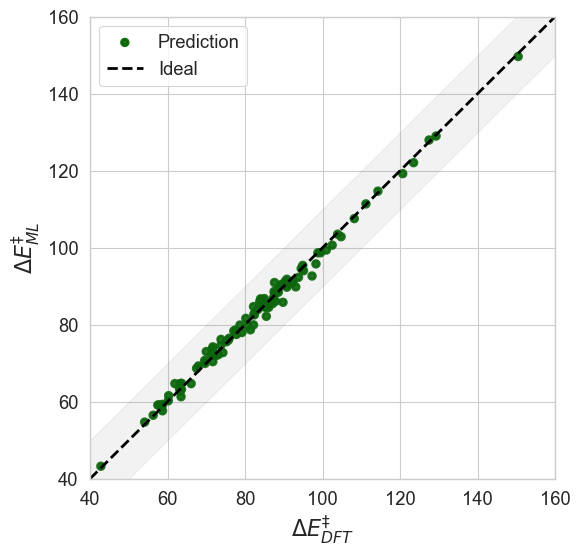

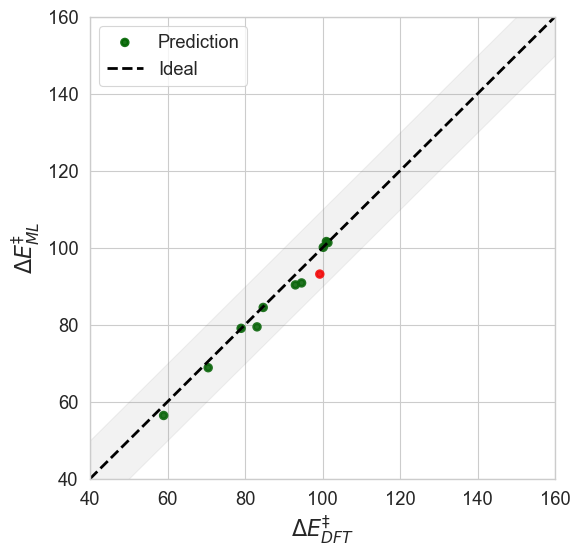

,Error Metric,Training Data,Test Data,Note
0,RMSE,1.5419 (kJ/mol),2.7283 (kJ/mol),(0.0 for perfect prediction)
1,RMSE/std,0.0864,0.2046,(0.0 for perfect prediction)
2,MAE,1.2306 (kJ/mol),1.9517 (kJ/mol),(0.0 for perfect prediction)
3,R2,0.9925,0.9581,(1.0 for perfect prediction)


In [227]:
test_size = 0.1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=29)
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train, Y_train)
Train_predictions = gbr_model.predict(X_train)
Test_predictions = gbr_model.predict(X_test)
print(len(X_test))
# Plot and save training data parity plot
parity_plot(Y_train, Train_predictions, "Training Data Parity Plot", "training_parity_plot_gbr.png")

# Plot and save test data parity plot
parity_plot(Y_test, Test_predictions, "Test Data Parity Plot", "test_parity_plot_gbr.png")

parity_stats_side_by_side(Y_train,Train_predictions,Y_test,Test_predictions,"Training Data","Test Data")  # print error metrics for training data

# print(X_test, Y_test, Test_predictions)
# print(Y_test-Test_predictions)

Catalyst: 7_och3_no2, DFT: 74.4, Predicted: 71.81058914350318, Difference: 2.5894108564968263
Catalyst: iminch32, DFT: 94.0, Predicted: 89.60240678326328, Difference: 4.397593216736723
Catalyst: 1C_7, DFT: 53.3, Predicted: 56.93751813238503, Difference: -3.6375181323850327
Catalyst: 2C_19, DFT: 79.7, Predicted: 74.91373101485962, Difference: 4.7862689851403815
Catalyst: DA2_th_th, DFT: 79.7, Predicted: 81.98766377202563, Difference: -2.287663772025624


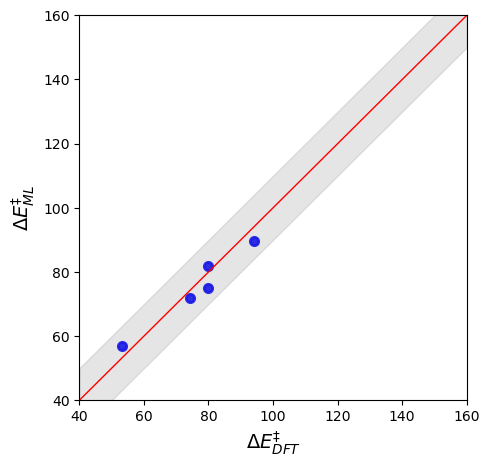

R2: 0.9224187339997588
MAE: 3.5396909925569178


In [228]:
df2 = pd.read_csv('../Data11test.csv')
df2['theta12'] = round(df2['theta1'] + df2['theta2'],2)
# Prepare the features for prediction
features_df2 = df2.drop(['Cu2-O4', 'Folder', 'Barrier', 'diamine', 'theta1', 'theta2'], axis=1)

# Make predictions
predictions_test12 = gbr_model.predict(features_df2)

# Calculate differences
differences = df2['Barrier'] - predictions_test12

# Print Folder, Actual, Predicted, and Difference
for folder, actual, predicted, difference in zip(df2['Folder'], df2['Barrier'], predictions_test12, differences):
    print(f"Catalyst: {folder}, DFT: {actual}, Predicted: {predicted}, Difference: {difference}")

# Plotting
plt.style.use('default')
plt.figure(figsize=(5, 5))
plt.scatter(df2['Barrier'], predictions_test12, color='blue', alpha=0.9, linewidths=2, marker ="o")
plt.plot([40, 160], [40, 160], color='red', linestyle='-', linewidth=1, markersize=12)
plt.xlim(40, 160)
plt.ylim(40, 160)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.2)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=14)
plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=14)
plt.show()

# Calculate R2 and MAE
r2 = r2_score(df2['Barrier'], predictions_test12)
mae = mean_absolute_error(df2['Barrier'], predictions_test12)

print('R2:', r2)
print('MAE:', mae)

In [222]:

shap.initjs()

# Create SHAP explainer and calculate SHAP values
explainerModel = shap.TreeExplainer(model=gbr_model)
shap_values = explainerModel.shap_values(features_df2)
print(shap_values)
base_value = explainerModel.expected_value
print(f"Base value (mean prediction): {base_value}")

shap_values_df = pd.DataFrame(shap_values, columns=features_df2.columns)

# Calculate the mean SHAP value for each feature
mean_shap_values = shap_values_df.mean()

# Print the average SHAP values
print("Average SHAP values for each feature:")
print(mean_shap_values)


# mean_shap_values_mapped = mean_shap_values.rename(index=feature_mapping)
# print("Average SHAP values for each feature with new labels:")
# print(mean_shap_values_mapped)

new_labels = [
    r'$\overline{\omega}_{\mathrm{Cu-O}}$',
    r'$\overline{\omega}_{\mathrm{Cu-N}}$',
    r'$\overline{\omega}_{\mathrm{O-Cu-O}}$',
    r'$\overline{\omega}_{\mathrm{N-Cu-N}}$',
    r'$\theta_{12}$',
]

# Function to map original feature names to new labels
def map_features(df, new_labels):
    original_features = df.columns.tolist()
    feature_mapping = dict(zip(original_features, new_labels))
    return df.rename(columns=feature_mapping), feature_mapping

# Map the feature names in both training and test sets
X_mapped, feature_mapping = map_features(X, new_labels)
features_df2_mapped, _ = map_features(features_df2, new_labels)

def plot_indiv_shap(i, fx_value1, x_p, y_p, x_b, y_b, name):
    feature_values_rounded = features_df2_mapped.iloc[i, :].apply(lambda x: round(x, 1))
    shap_values_rounded = shap_values[i]
    
    # Compute the expected value plus SHAP values
    fx_value = np.round(base_value + shap_values_rounded.sum(), 1)
    

    print(fx_value)
    
    shap.force_plot(explainerModel.expected_value, shap_values[i], feature_values_rounded, matplotlib=True, show=False)
    ax = plt.gca()
    for text in ax.texts:
        text.set_fontsize(13)
        # if text.get_text() == fx_value1:
        #     text.set_position((text.get_position()[0] + x_p, text.get_position()[1] + y_p))
        if text.get_text() == "base value":
            text.set_position((text.get_position()[0] + x_b, text.get_position()[1] + y_b))

    # for j, value in enumerate(shap_values_rounded):
    #     ax.text(j, 0, f"{value:.2f}", ha='center', va='bottom', fontsize=12, color='black')


    ax = plt.gca()
    for text in ax.texts:
        if text.get_text().startswith("f(x)"):
            text.set_text(f"f(x) = {float(fx_value)}")
        elif text.get_text().startswith(fx_value1):
            text.set_text(f"")
    
    

    plt.savefig(name, format='png', dpi=700, bbox_inches='tight')
    # plt.savefig(name)  # Save the figure
    plt.show()



[[ -0.83161315  -6.85987149  -7.62702478   3.64112428   0.50034541]
 [  1.73495991   9.29203325  -5.70746233   0.21503637   1.08021072]
 [  1.11917222 -13.11272788  -7.57685701  -0.59318508  -5.88651299]
 [  3.52580675  -2.60128458  -5.11553633  -0.59039313  -3.29249056]
 [  6.97785546  -2.11290804  -7.2095851   -0.64413976   1.98881234]]
Base value (mean prediction): [82.98762887]
Average SHAP values for each feature:
Mean_Cu-O      2.505236
Mean_Cu-N     -3.078952
Mean_O-Cu-O   -6.647293
Mean_N-Cu-N    0.405689
theta12       -1.121927
dtype: float64


[71.8]


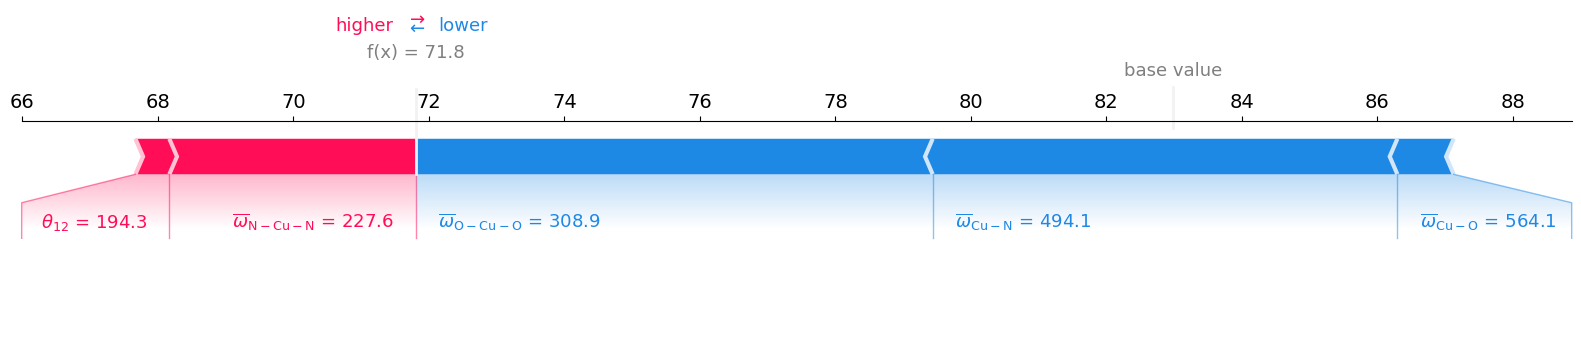

In [220]:
fx_value = "71.81" 
x_p = 0.8
y_p = 0.08
x_b = 0
y_b = -0.05
plot_indiv_shap(0, fx_value, x_p, y_p, x_b, y_b, 'first.png')

[89.6]


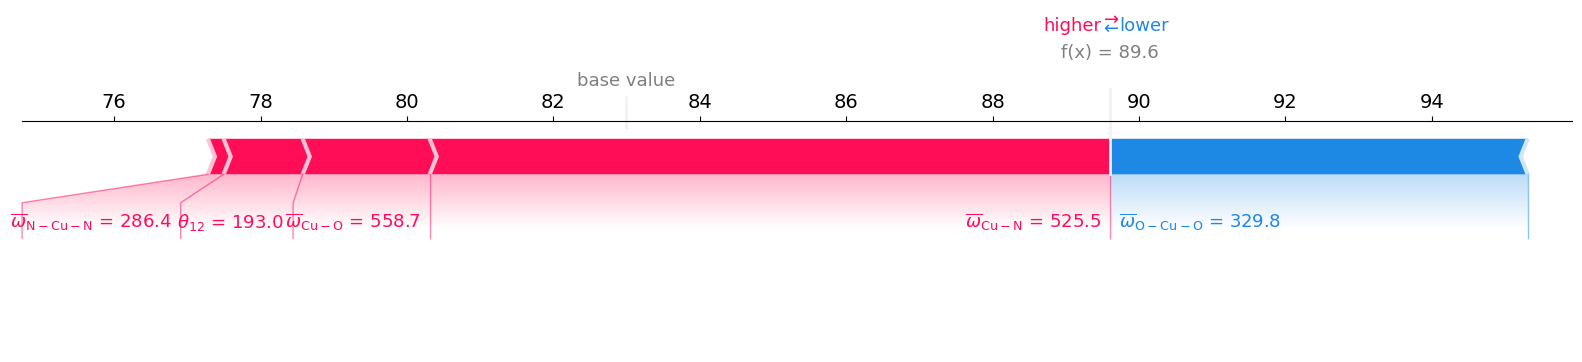

In [211]:
fx_value = "89.60"
x_p = 0.7
y_p = 0.08
x_b = 0
y_b = -0.08
plot_indiv_shap(1, fx_value, x_p, y_p, x_b, y_b, 'second.png')

[56.9]


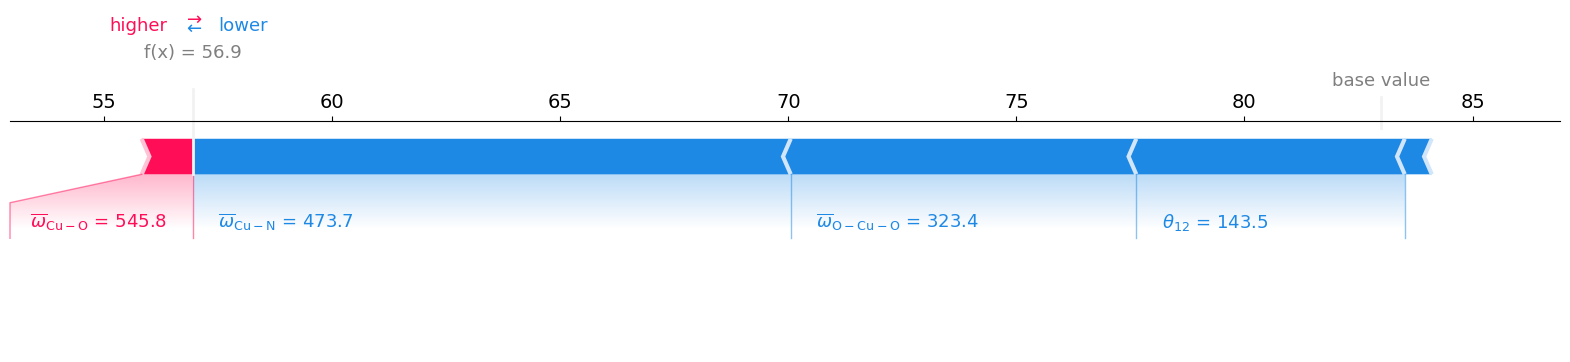

In [212]:
fx_value = "56.94"
x_p = 1.1
y_p = 0.08
x_b = 0
y_b = -0.08
plot_indiv_shap(2, fx_value, x_p, y_p, x_b, y_b, 'third.png')


[74.9]


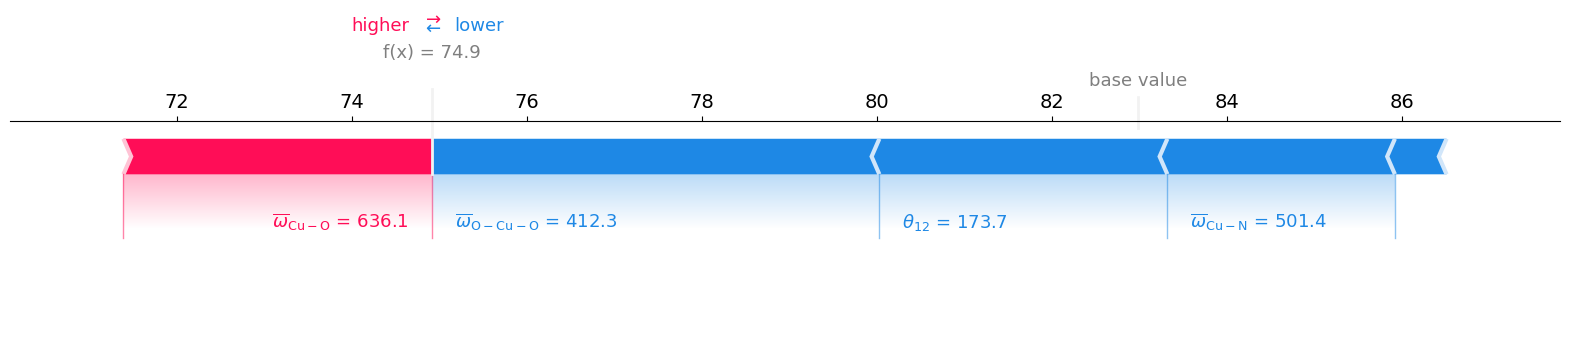

In [213]:
fx_value = "74.91"
x_p = 0.6
y_p = 0.08
x_b = 0
y_b = -0.08
plot_indiv_shap(3, fx_value, x_p, y_p, x_b, y_b, 'fourth.png')

[82.]


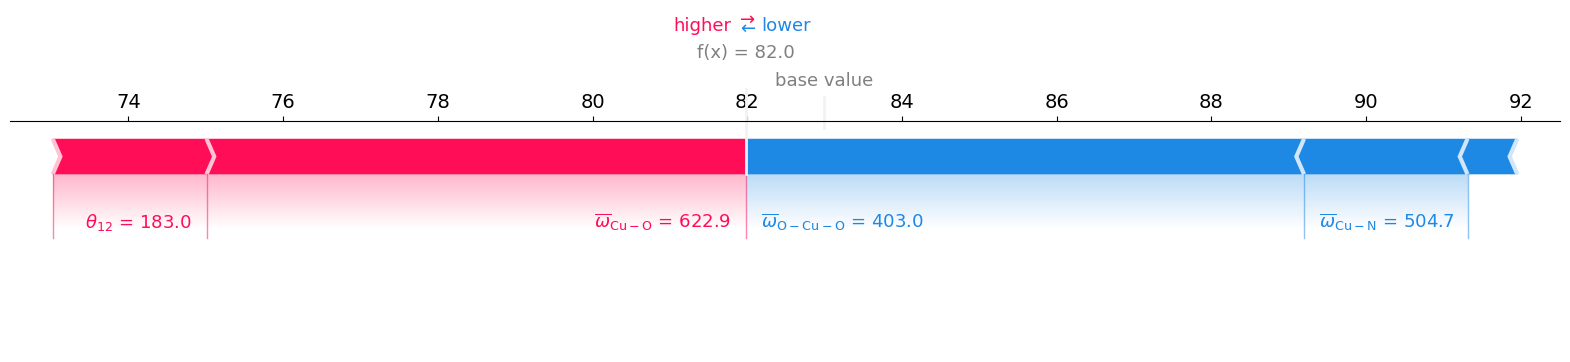

In [214]:
fx_value = "81.99"
x_p = 0.7
y_p = 0.08
x_b = 0
y_b = -0.08
plot_indiv_shap(4, fx_value, x_p, y_p, x_b, y_b, 'fifth.png')

In [12]:
# shap.initjs()

# def plot_indiv_shap(i):
#     shap.force_plot(explainerModel.expected_value, shap_values[i], X.iloc[[i]], show=False, matplotlib=True)

# explainerModel = shap.TreeExplainer(model = gbr_model)
# shap_values = explainerModel.shap_values(X)
# shap.summary_plot(shap_values, X)

# plot_indiv_shap(2)